# Inventory Monitoring at Distribution Centers

## 1. Project description

Distribution centers often use robots to move objects as a part of their operations. Objects are carried in bins which can contain multiple objects.

The objective of this project is to develop a model capable of counting the number of objects within each bin. Such a system can be utilized for inventory tracking and ensuring accurate item quantities in delivery consignments.

To construct this project, AWS SageMaker will be used to retrieve data from a database, preprocess it, and train a machine learning model. Additionally, an endpoint will be created using SageMaker to deploy the trained model. This endpoint can serve as an interface for making predictions on new data, allowing the model to be integrated into the distribution center's operations.

## 2. About the dataset

The Amazon Bin Image Dataset contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations. Each image is accompanied by a metadata file containing information such as the object count, dimensions, and object types. The task at hand involves classifying the number of objects within each bin.

Initially, a restricted subset of images will be utilized to test the feasibility of the idea and validate the machine learning pipeline. This subset will serve as a proof of concept to ensure that the pipeline functions as intended. Once the initial testing phase is completed and the machine learning pipeline is deemed successful, the model can then be retrained with additional data.

## 3. Imports

In [1]:
import os
import json
import boto3
import random
import shutil

from tqdm import tqdm

import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

from IPython.display import Image, display

[2023-06-15 19:55:27.388 Lucass-MacBook-Air.local:60993 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## 4. Data Preparation

In the following code cell, a folder named train_data is created. The training data is then downloaded and organized into subfolders. Each subfolder corresponds to the number of objects in the images it contains. For example, the folder labeled 1 contains images with a single object, while other folders may have different object counts. The number of the folder corresponds to the class name.

In [18]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [07:57<00:00,  2.57it/s]


100%|██████████| 2299/2299 [15:52<00:00,  2.41it/s]


100%|██████████| 2666/2666 [21:47<00:00,  2.04it/s]   


100%|██████████| 2373/2373 [15:42<00:00,  2.52it/s]


100%|██████████| 1875/1875 [12:14<00:00,  2.55it/s]


After successfully downloading the images, we can look at the class distribution to gain insights into the dataset's composition. 

In [59]:
# Using plotly, create bar plot of number_imgs versus number_objects
import plotly.graph_objects as go

number_objects = ['1', '2', '3', '4', '5']
number_imgs = [len(d[n]) for n in d]
imgs_total = sum(number_imgs)

fig = go.Figure(data=[go.Bar(x=number_objects, y=number_imgs)])
# Add title and axis labels
fig.update_layout(title_text='Number of Images per Number of Objects in Image', xaxis_title_text='Number of Objects', yaxis_title_text='Number of Images')
# Set width and height of the figure
fig.update_layout(width=600, height=500)
fig.show()

The class distribution plot reveals noticeable variations in the number of images across different classes. Notably, class 1, representing images with a single object, has fewer than half the instances compared to class 3. In order to test the machine learning pipeline we will proceed with the data as it currently is, but an opportunity for improvement is to get more data and equalize the number of instances per class.

All data is contained in the train_data folder. We need to split the data into train, test and validation images in order to evaluate the performance of the models. The following code randomly selects 10% of the images of each class and moves them to the validation folder, preserving the folder structure where each subfolder corresponds to the image class. The same procedure is repeated with the test images, selecting 5% of the images. After splitting the data, all images all uploaded to S3.

In [31]:
# Set the paths
train_folder = 'train_data'
test_folder = 'test_data'
validation_folder = 'validation_data'

# Create test and validation folders if they don't exist
os.makedirs(test_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

# Define the number of images to select
test_set_ratio = 0.05
validation_set_ratio = 0.1

# Iterate over each class directory
for class_dir in os.listdir(train_folder):
    class_path = os.path.join(train_folder, class_dir)
    
    if os.path.isdir(class_path):
        image_list = os.listdir(class_path)

        # Shuffle the image list and split it
        random.shuffle(image_list)
        test_set_size = int(len(image_list) * test_set_ratio)
        validation_set_size = int(len(image_list) * validation_set_ratio)
        test_set = image_list[:test_set_size]
        validation_set = image_list[test_set_size:test_set_size+validation_set_size]

        # Move test images to the test folder
        for image in test_set:
            src = os.path.join(class_path, image)
            dst = os.path.join(test_folder, class_dir, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.move(src, dst)

        # Move validation images to the validation folder
        for image in validation_set:
            src = os.path.join(class_path, image)
            dst = os.path.join(validation_folder, class_dir, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.move(src, dst)

# Upload the train, test and validation data to S3
s3_bucket = 'object-counter-project'
s3_prefix = 'data'
s3_client = boto3.client('s3')

for data_type in ['train', 'test', 'validation']:
    prefix = f'{s3_prefix}/{data_type}'
    path = f'{data_type}_data'
    print(f'Uploading {path} data')
    for class_dir in os.listdir(path):
        class_path = os.path.join(path, class_dir)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                s3_client.upload_file(os.path.join(class_path, file_name), s3_bucket, os.path.join(prefix, class_dir, file_name))

Uploading train_data data
Uploading test_data data
Uploading validation_data data


In [3]:
input_path = f's3://{s3_bucket}/{s3_prefix}'
print(f'Input path: {input_path}')

Input path: s3://object-counter-project/data


## 5. Model Training

The convolutional neural network ResNet-50 was chosen as a first try for our problem. ResNet-50 is a popular deep learning architecture for computer vision tasks. It belongs to the ResNet family of models and has 50 layers. It uses skip connections to address the vanishing gradient problem in deep networks. PyTorch Hub provides a pre-trained ResNet-50 model that can be used for tasks like image classification. This pre-trained model saves time and resources by leveraging knowledge learned from a large dataset.

The following code uses the SageMaker Python SDK to create a PyTorch estimator. It then creates a HyperparameterTuner that launches a hyperaparameter tuning job that tries different values for the learning rate and batch size.

The results show that a lower learning rate gives a better performance in termos of a lower cross entropy loss. 

More computing resources could be dedicated to hyperparameter tuning, but as a first try we will continue with a learning rate of 0.003 and a batch size of 32, retraining the model with 20 epochs.

In [5]:
role = "arn:aws:iam::860372235077:role/service-role/AmazonSageMaker-ExecutionRole-20230609T125000"
sagemaker_session = sagemaker.Session()

In [196]:
hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16, 32, 64]),
}

objective_metric_name = "Valid Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Valid Loss", "Regex": "Final Validation Loss: ([0-9\\.]+)"}]

estimator = PyTorch(entry_point='train.py',
                    base_job_name='object-counter',
                    role=role,
                    framework_version='2.0.0',
                    py_version='py310',
                    instance_count=1,
                    instance_type='ml.c5.2xlarge',
                    hyperparameters=hyperparameters,
                    output_path=f's3://{s3_bucket}/training_output')

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type
)

In [197]:
tuner.fit({'training': input_path}, wait=True, logs='All')

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230614-1612


.........................................................................................................................................................................................................................................................................................................................!


In [198]:
exp = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name='pytorch-training-230614-1612')

training_jobs = exp.dataframe()

training_jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""16""",0.032362,pytorch-training-230614-1612-003-62a6e1db,Completed,1.5876,2023-06-14 16:38:07-03:00,2023-06-14 16:47:25-03:00,558.0
3,"""16""",0.018324,pytorch-training-230614-1612-001-1b54eb40,Completed,1.5773,2023-06-14 16:13:56-03:00,2023-06-14 16:24:24-03:00,628.0
0,"""64""",0.060183,pytorch-training-230614-1612-004-a7721d24,Completed,1.5744,2023-06-14 16:48:19-03:00,2023-06-14 16:59:18-03:00,659.0
2,"""64""",0.003724,pytorch-training-230614-1612-002-e1aa4ddb,Completed,1.4470,2023-06-14 16:25:52-03:00,2023-06-14 16:37:01-03:00,669.0


In [201]:
best_estimator=tuner.best_estimator()
best_estimator.hyperparameters()


2023-06-14 19:38:05 Starting - Found matching resource for reuse
2023-06-14 19:38:05 Downloading - Downloading input data
2023-06-14 19:38:05 Training - Training image download completed. Training in progress.
2023-06-14 19:38:05 Uploading - Uploading generated training model
2023-06-14 19:38:05 Completed - Resource reused by training job: pytorch-training-230614-1612-003-62a6e1db


{'_tuning_objective_metric': '"Valid Loss"',
 'batch_size': '"64"',
 'epochs': '1',
 'learning_rate': '0.003723649270709385',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"object-counter-2023-06-14-19-12-33-358"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://object-counter-project/object-counter-2023-06-14-19-12-33-358/source/sourcedir.tar.gz"'}

In [204]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=1000)

hyperparameters = {
    'batch_size': 32,
    'epochs': 20,
    'learning_rate': 0.003
}

estimator = PyTorch(entry_point='train.py',
                    base_job_name='object-counter',
                    role=role,
                    framework_version='2.0.0',
                    py_version='py310',
                    instance_count=1,
                    instance_type='ml.p3.2xlarge',
                    hyperparameters=hyperparameters,
                    output_path=f's3://{s3_bucket}/training_output',
                    rules=rules, 
                    profiler_config=profiler_config)

In [205]:
estimator.fit({'training': input_path}, wait=True, logs='All')

Using provided s3_resource


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: object-counter-202

2023-06-14 20:38:54 Starting - Starting the training job...
2023-06-14 20:39:20 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-06-14 20:40:30 Downloading - Downloading input data...
2023-06-14 20:41:05 Training - Downloading the training image.....................
2023-06-14 20:44:51 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-14 20:44:52,651 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-14 20:44:52,666 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-14 20:44:52,677 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-14 20:44:52,679 sagem

During the course of 20 epochs, the validation accuracy exhibited a slight improvement, rising from an initial value of 0.3141 to a higher value of 0.3593. Additionally, the model's performance on the test set yielded an accuracy of 0.3584. While these advancements demonstrate progress, it is evident that further improvements are required before deploying the model in a production environment.

To enhance the accuracy of the model, several strategies can be pursued. First, extending the training process by running additional epochs can provide the model with more opportunities to refine its learned representations and optimize its decision boundaries. This extended training period allows the model to gradually learn from the training data, potentially leading to enhanced generalization capabilities.

Moreover, augmenting the available training data can contribute to performance gains. By introducing a more diverse and comprehensive dataset, the model can encounter a wider range of patterns and variations, enabling it to learn more robust and discriminative features.

The usage statistics below were generated from the profiler report. It shows that the GPU was underutilized, with a maximum utilization of only 18% throughout the training process. The reason for the underutilization of the GPU can be attributed to the small batch size used during training. A small batch size means that fewer samples are processed in parallel, leading to lower GPU utilization.

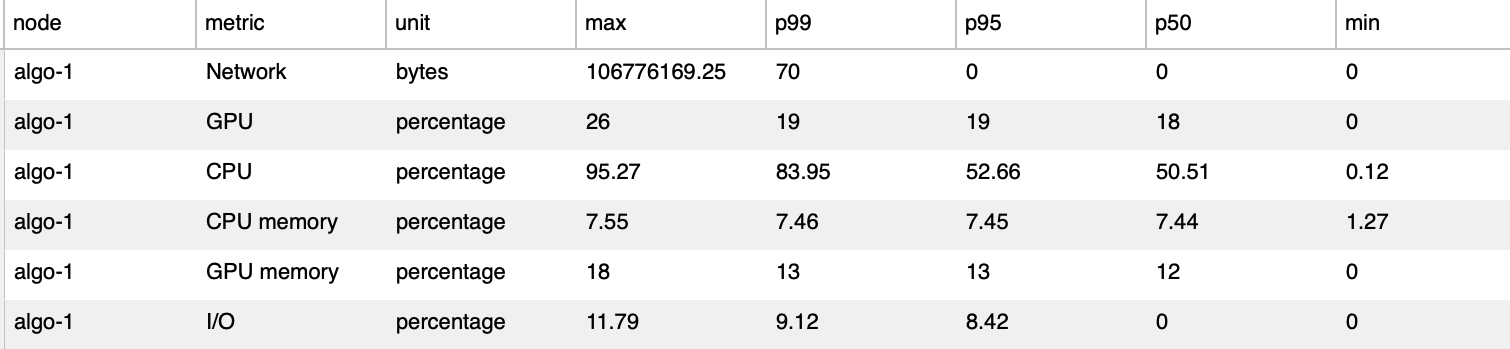

In [8]:
# System usage statistics from profiler report
Image(filename='system-usage-statistics.jpg')

## 6. Model Deploying and Querying

Finally, we can host our trained model on AWS Sagemaker to make it accessible and available for inference or predictions. This allows us to deploy the model as a web service, allowing other applications or users to send requests and receive predictions in real-time. By hosting our model on AWS Sagemaker, we can take advantage of its managed infrastructure, auto-scaling capabilities, and easy integration with other AWS services, ensuring high availability, scalability, and efficient management of our model's deployment.

In [206]:
model_location = estimator.model_data
model_location

's3://object-counter-project/training_output/object-counter-2023-06-14-20-38-51-958/output/model.tar.gz'

In [207]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )
        
pytorch_model = PyTorchModel(model_data=model_location,
                             role=role,
                             entry_point="deploy.py",
                             py_version="py310",
                             framework_version="2.0.0",
                             predictor_cls=ImgPredictor
                            )

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.2xlarge")

INFO:sagemaker:Repacking model artifact (s3://object-counter-project/training_output/object-counter-2023-06-14-20-38-51-958/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-860372235077/pytorch-inference-2023-06-14-21-12-55-079/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-06-14-21-14-46-298
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-06-14-21-14-47-738
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-06-14-21-14-47-738


----!

The following code randomly selects one image from the specified class and sends it to the endpoint for prediction. The result of the inference made by the model is showed below the sampled imaged.

Sending the following image to AWS SageMaker endpoint:


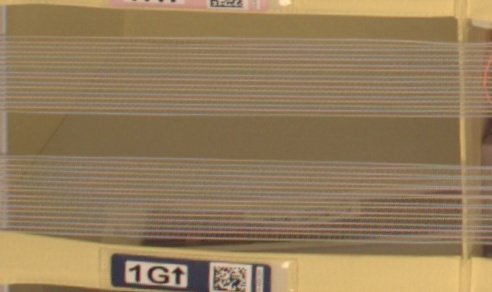

Expecting the following class: 1
Predicted class: 1


In [217]:
from PIL import Image
import io
import numpy as np

test_class = '1'
test_image = os.path.join(test_folder, test_class, random.choice(os.listdir(os.path.join(test_folder, test_class))))
with open(test_image, 'rb') as f:
    payload = f.read()
    print('Sending the following image to AWS SageMaker endpoint:')
    display(Image.open(io.BytesIO(payload)))
    print(f'Expecting the following class: {test_class}')
    response = predictor.predict(payload, initial_args = {'ContentType': 'image/jpeg'})
    prediction = np.argmax(response, 1) + 1
    print(f'Predicted class: {prediction[0]}')


In [218]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-06-14-21-14-47-738
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-06-14-21-14-47-738
